# Modelling

## Importing libraries

In [16]:
from __future__ import print_function
import itertools
import numpy as np
import pylab as plt
import shap
import vaex
import vaex.ml
import vaex.ml.metrics
import vaex.ml.tensorflow

In [17]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras import Sequential
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, TimeDistributed, Conv1D, MaxPooling1D,Flatten
from keras_tuner.tuners import BayesianOptimization
from keras.regularizers import l2,l1, l1_l2

In [18]:
# data manipulation package
import pandas as pd

# configure pandas display settings
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 50)

# data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# configure seaborn display settings
sns.set_context("notebook", rc={"font.size": 8, "axes.titlesize": 8, "axes.labelsize": 13})


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Conv1D
from keras.layers import Dropout, Input
from keras import initializers
from keras.layers import MaxPooling1D
from keras.models import Model 
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM

In [20]:
# library containing utility functions
import utils
# library containing data exploration functions
import exploration
# library containing data processing functions
import processing
# library containing data visualization functions
import visualization

In [21]:
from tcn import TCN, tcn_full_summary, compiled_tcn
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import get_session
tf.compat.v1.disable_v2_behavior()
import shap
shap.initjs()

In [22]:
import random
seed=21
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [23]:
df_train= vaex.open('../vaex/data_train.hdf5')
df_test= vaex.open('../vaex/data_test.hdf5')

In [24]:
df_train.head()

#    Engine_no    Cycle    Altitude     Mach    TRA      T2     T24      T30      T50     P2    P15     P30       Nf       Nc    epr    Ps30     phi      NRf      NRc     BPR    farB    htBleed    Nf_dmd    PCNfR_dmd    W31      W32    RUL
  0            1        1     -0.0005   0.0004    100  518.67  642.36  1583.23  1396.84  14.62  21.61  553.97  2387.96  9062.17    1.3   47.3   522.31  2388.01  8145.32  8.4246    0.03        391      2388          100  39.11  23.3537    258
  1            1        2      0.0008  -0.0003    100  518.67  642.5   1584.69  1396.89  14.62  21.61  554.55  2388     9061.78    1.3   47.23  522.42  2388.03  8152.85  8.4403    0.03        392      2388          100  38.99  23.4491    257
  2            1        3     -0.0014  -0.0002    100  518.67  642.18  1582.35  1405.61  14.62  21.61  554.43  2388.03  9070.23    1.3   47.22  522.03  2388     8150.17  8.3901    0.03        391      2388          100  38.85  23.3669    256
  3            1        4     -0.002    0.0001    100  518.67  642.92  1585.61  1392.27  14.62  21.61  555.21  2388     9064.57    1.3   47.24  522.49  2388.08  8146.56  8.3878    0.03        392      2388          100  38.96  23.2951    255
  4            1        5      0.0016   0         100  518.67  641.68  1588.63  1397.65  14.62  21.61  554.74  2388.04  9076.14    1.3   47.15  522.58  2388.03  8147.8   8.3869    0.03        392      2388          100  39.14  23.4583    254
  5            1        6      0.0011  -0.0005    100  518.67  642.24  1584.09  1400.01  14.62  21.61  554.75  2388     9074.98    1.3   47.07  522.42  2388.02  8144.92  8.4152    0.03        393      2388          100  38.92  23.4281    253
  6            1        7     -0.0038   0.0002    100  518.67  642.58  1585.61  1401.09  14.62  21.61  554.58  2388.04  9074.65    1.3   47.38  522.46  2388.02  8147.05  8.3842    0.03        391      2388          100  38.84  23.4087    252
  7            1        8     -0.0007  -0.0005    100  518.67  642.32  1588.32  1397.08  14.62  21.6   554.85  2388.06  9063.54    1.3   47.31  522.1   2387.97  8157.34  8.419     0.03        391      2388          100  39.05  23.459     251
  8            1        9     -0.0026   0         100  518.67  641.64  1587.81  1406.51  14.62  21.61  554.13  2388.04  9067.2     1.3   47.31  521.83  2388.01  8147.2   8.4091    0.03        392      2388          100  38.99  23.4693    250
  9            1       10      0.0019  -0.0002    100  518.67  642.42  1587.39  1402.25  14.62  21.61  554.78  2387.99  9070.04    1.3   47.35  521.96  2387.99  8152.86  8.3987    0.03        391      2388          100  38.94  23.4781    249

In [25]:
dataschema = ['Engine_no', 'Cycle', 'Altitude', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc',
              'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']
dataframes = utils.load_data('RUL', ['RUL'], dataschema)
#adding rul
dataframes = processing.extract_rul(dataframes)

# list of indicators
indicators = dataschema[2:]

  0%|          | 0/3 [00:00<?, ?it/s]


------------------------------
---------train_FD003----------
------------------------------
Number of rows : 24720 
Number of columns : 26 
------------------------------
Engine_no      int64
Cycle          int64
Altitude     float64
Mach         float64
TRA          float64
T2           float64
T24          float64
T30          float64
T50          float64
P2           float64
P15          float64
P30          float64
Nf           float64
Nc           float64
epr          float64
Ps30         float64
phi          float64
NRf          float64
NRc          float64
BPR          float64
farB         float64
htBleed        int64
Nf_dmd         int64
PCNfR_dmd    float64
W31          float64
W32          float64

------------------------------
----------RUL_FD003-----------
------------------------------
Number of rows : 100 
Number of columns : 1 
------------------------------
RUL    int64

------------------------------
----------test_FD003----------
------------------------------
Numb

## Missing values and duplicate row check

In [26]:
duplicated_data = exploration.duplicate_rows(dataframes)

  0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------
--------------------------------------------------

train_FD003 has 0 duplicated rows.

--------------------------------------------------
--------------------------------------------------

test_FD003 has 0 duplicated rows.



In [27]:
missing_data = exploration.missing_values(dataframes)

  0%|          | 0/2 [00:00<?, ?it/s]

--------------------------------------------------
--------------------------------------------------

train_FD003 has 27 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

--------------------------------------------------
--------------------------------------------------

test_FD003 has 27 columns.
There are 0 columns that have missing values.


Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []

## Exploratory Data Analysis

### Training dataset

#### Statistical insights

In [28]:
df_train.describe()

invalid value encountered in sqrt


Engine_no               Cycle                 Altitude  \
data_type              int64               int64                  float64   
count                  24720               24720                    24720   
NA                         0                   0                        0   
mean       48.63187702265372  139.07706310679612  -2.3741909385113323e-05   
std                29.348391           98.844676                 0.002194   
min                        1                   1                  -0.0086   
max                      100                 525                   0.0086   

                             Mach      TRA                 T2  \
data_type                 float64  float64            float64   
count                       24720    24720              24720   
NA                              0        0                  0   
mean       5.0687702265372364e-06    100.0  518.6699999999711   
std                      0.000294      0.0           0.000204   
min                       -0.0006    100.0             518.67   
max                        0.0007    100.0             518.67   

                         T24                 T30                T50  \
data_type            float64             float64            float64   
count                  24720               24720              24720   
NA                         0                   0                  0   
mean       642.4578580097086  1588.0791751618115  1404.471212378641   
std                 0.523021             6.81028           9.772981   
min                   640.84              1564.3            1377.06   
max                   645.11             1615.39            1441.16   

                          P2                P15                P30  \
data_type            float64            float64            float64   
count                  24720              24720              24720   
NA                         0                  0                  0   
mean       14.62000000000001  21.59584101941766  555.1438078478966   
std                      NaN           0.018116           3.437273   
min                    14.62              21.45             549.61   
max                    14.62              21.61             570.49   

                          Nf                Nc                 epr  \
data_type            float64           float64             float64   
count                  24720             24720               24720   
NA                         0                 0                   0   
mean       2388.071554611646  9064.11080906149  1.3012317961165607   
std                 0.158282          19.97989            0.003485   
min                   2386.9           9017.98                1.29   
max                   2388.6           9234.35                1.32   

                         Ps30                phi                NRf  \
data_type             float64            float64            float64   
count                   24720              24720              24720   
NA                          0                  0                  0   
mean       47.415706715210355  523.0508725728153  2388.071643203879   
std                  0.300068           3.255248           0.158117   
min                     46.69             517.77            2386.93   
max                     48.44              537.4            2388.61   

                         NRc                BPR                  farB  \
data_type            float64            float64               float64   
count                  24720              24720                 24720   
NA                         0                  0                     0   
mean       8144.202916262149  8.396175784789648  0.030000000000000894   
std                16.503784            0.06051                   NaN   
min                  8099.68             8.1563                  0.03   
max                  8290.55             8.5705                  0.03   

                     htBleed  Nf_dmd

- The number of engines in this dataset = {{len(set(df_train3.Engine_no))}}
- Minimum engine remaining useful life = {{df_train.groupby(['Engine_no'])['RUL'].max().min()}} cycles
- Maximum engine remaining useful life = {{df_train3['RUL'].max()}} cycles
- The operational setting TRA is the same for the whole dataset = 100
- T2 is the same for the whole dataset = 518.67
- P2 contains some noise
- farB contains some noise
- Nf_dmd is constant for the whole dataset = 2388.0
- PCNfR_dmd is constant for the whole dataset = 100

#### Insights from plots

Each engine runs for different cycles. The sensor data is recorded until engine failure in the train dataset. Therefore, one can infer the last cycle of a particular engine as the maximum number of cycles for that engine.

In [29]:
cycle_engine= df_train[['Engine_no','Cycle']].groupby('Engine_no',agg='max').sort(by="Cycle_max",ascending= True)
cycle_engine.head()

#    Engine_no    Cycle_max
  0           99          145
  1           80          147
  2          100          152
  3           76          153
  4           91          156
  5           92          158
  6           50          161
  7           53          164
  8           66          165
  9           79          166

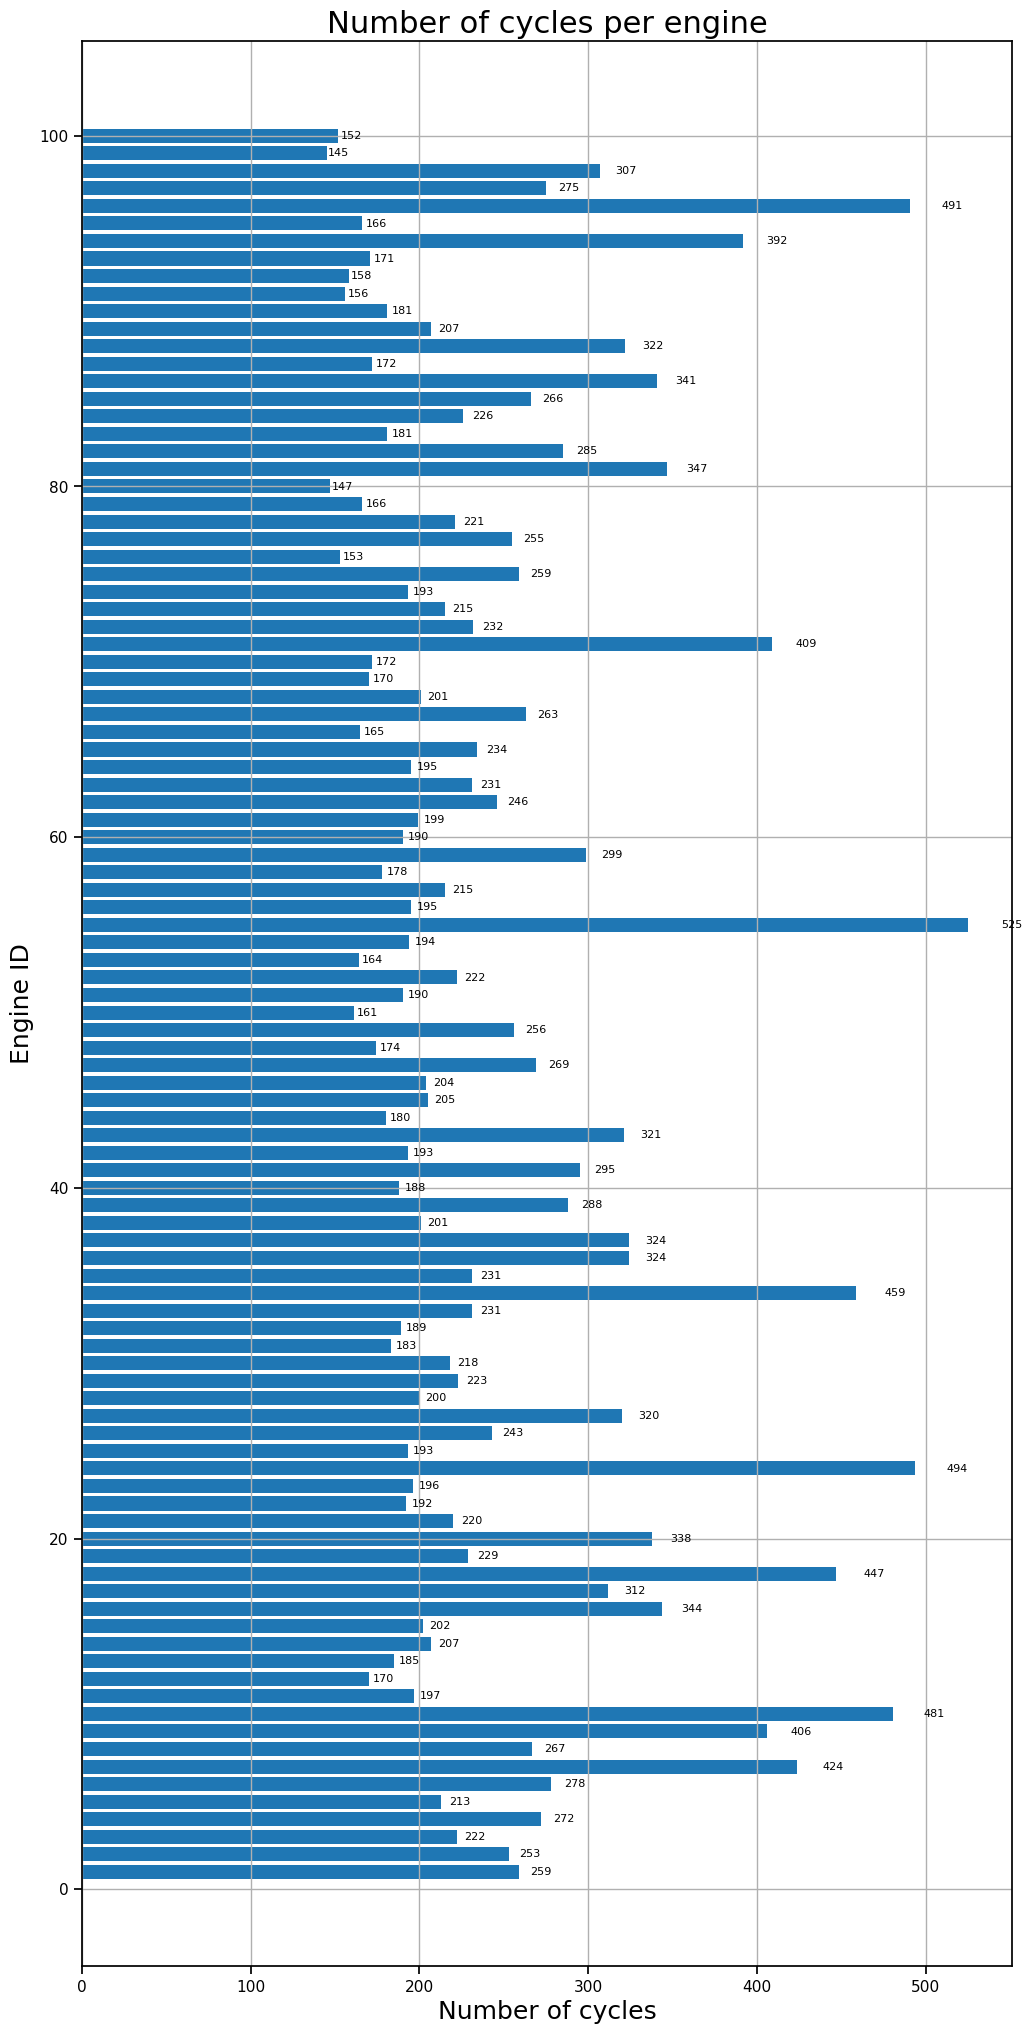

In [30]:
fig,ax= plt.subplots(figsize=(12,25))
plots= ax.barh(cycle_engine.Engine_no.values,cycle_engine.Cycle_max.values)
ax.set_title("Number of cycles per engine",fontsize=22)
ax.set_xlabel("Number of cycles",fontsize=18)
ax.set_ylabel("Engine ID",fontsize=18)
ax.grid(True)
#for annotating bars
for p in plots:
    width= p.get_width()
    plt.text(1.05*width,p.get_y()+0.5*p.get_height(), '%d' % int(width), ha='center', va='center')

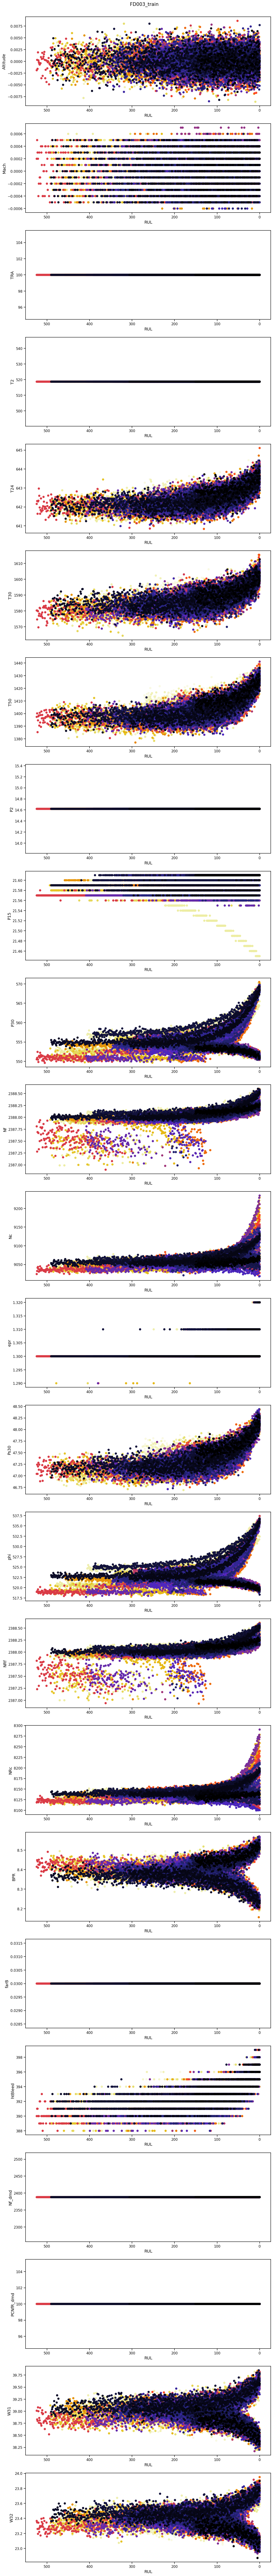

In [31]:
dataframe=df_train.to_pandas_df()

engines_count = dataframe.Engine_no.nunique()
    # create subplots
fig, axes = plt.subplots(nrows=len(indicators), ncols=1, figsize=(14, 130))
    # create and adjust superior title
fig.suptitle("FD003_train", fontsize=15)
fig.subplots_adjust(top=.975)
    # create palette
    #p = _sns.color_palette("coolwarm", engines_count)
# iterate over indicators
for i, indicator in enumerate(indicators):
        # plot scatter plot of each indicator
        plt.sca(axes[i])
        plt.scatter(dataframe.RUL,dataframe.loc[:,indicator],c=dataframe.Engine_no,cmap='CMRmap_r')
        plt.xlabel("RUL")
        plt.ylabel(indicator)
        # invert x-axis
        axes[i].invert_xaxis()


Plotting line plots gives more clear insights regarding variance and noisy signals. Thus we will plot the sensors against the target,"RUL".

In [32]:
df_grouped = df_train.groupby(['RUL']).agg(['min', 'mean', 'max'])
df_grouped

#    RUL    Engine_no_min    Cycle_min    Altitude_min    Mach_min    TRA_min    T2_min    T24_min    T30_min    T50_min    P2_min    P15_min    P30_min    Nf_min    Nc_min    epr_min    Ps30_min    phi_min    NRf_min    NRc_min    BPR_min    farB_min    htBleed_min    Nf_dmd_min    PCNfR_dmd_min    W31_min    W32_min    Engine_no_mean    Cycle_mean    Altitude_mean            Mach_mean               TRA_mean    T2_mean    T24_mean           T30_mean            T50_mean            P2_mean             P15_mean            P30_mean    Nf_mean             Nc_mean            epr_mean            Ps30_mean          phi_mean           NRf_mean            NRc_mean           BPR_mean           farB_mean             htBleed_mean    Nf_dmd_mean    PCNfR_dmd_mean    W31_mean           W32_mean            Engine_no_max    Cycle_max    Altitude_max    Mach_max    TRA_max    T2_max    T24_max    T30_max    T50_max    P2_max    P15_max    P30_max    Nf_max    Nc_max    epr_max    Ps30_max    phi_max    NRf_max    NRc_max    BPR_max    farB_max    htBleed_max    Nf_dmd_max    PCNfR_dmd_max    W31_max    W32_max
0    0      1                145          -0.0052         -0.0005     100.0      518.67    642.71     1595.19    1417.81    14.62     21.45      550.38     2388.14   9018.74   1.3        47.95       518.31     2388.15    8100.35    8.1932     0.03        394            2388          100.0            38.2       22.9537    50.5              247.2         -5.2000000000000024e-05  -7.999999999999995e-06  100.0       518.67     643.5971999999999  1603.3731000000002  1428.9103999999998  14.62               21.598900000000004  559.0577    2388.3795           9106.977400000002  1.3082000000000003  48.18030000000001  526.9397           2388.3791999999994  8175.779399999999  8.399196           0.030000000000000016  396.55          2388.0         100.0             38.93729999999999  23.383357999999998  100              525          0.0077          0.0005      100.0      518.67    645.11     1612.73    1441.16    14.62     21.61      570.22     2388.59   9234.35   1.32       48.44       537.4      2388.61    8290.55    8.5676     0.03        399            2388          100.0            39.82      23.9505
1    1      1                144          -0.006          -0.0005     100.0      518.67    642.49     1590.61    1415.54    14.62     21.45      550.47     2388.13   9017.98   1.3        47.78       518.76     2388.13    8100.6     8.1889     0.03        394            2388          100.0            38.2       22.96      50.5              246.2         -0.00011599999999999997  2.2999999999999997e-05  100.0       518.67     643.5553           1602.3576999999996  1427.3289000000002  14.62               21.5984             558.9093    2388.3634           9104.884600000001  1.3068              48.131             526.7697999999999  2388.3617           8174.128200000001  8.395411           0.030000000000000016  396.37          2388.0         100.0             38.9405            23.374226000000004  100              524          0.0052          0.0006      100.0      518.67    644.45     1615.39    1439.98    14.62     21.61      570.49     2388.6    9228.33   1.32       48.44       536.75     2388.59    8277.76    8.5705     0.03        399            2388          100.0            39.78      23.894
2    2      1                143          -0.0051         -0.0005     100.0      518.67    642.51     1594.38    1414.44    14.62     21.45      550.64     2388.08   9027.61   1.3        47.91       518.76     2388.12    8101.28    8.1563     0.03        394            2388          100.0            38.26      22.9705    50.5              245.2         -0.00014900000000000002  3.7000000000000005e-05  100.0       518.67     643.4797           1602.3551           1427.2806999999998  14.62               21.598600000000005  558.8129    2388.3567000000003  9104.513299999999  1.3065              48.14379999999999  526.7284           2388.3573999999994  8173.4965    

In [33]:
df_grouped = dataframe.groupby(['RUL']).agg(['min', 'mean', 'max'])
# df_grouped[str(indicator+"_max")]
# plt.plot(df_train.RUL,df_grouped[str(indicator+"_max")])
df_grouped

Engine_no            Cycle             Altitude                      Mach  \
          min  mean  max   min   mean  max      min      mean     max     min   
RUL                                                                             
0           1  50.5  100   145  247.2  525  -0.0052 -0.000052  0.0077 -0.0005   
1           1  50.5  100   144  246.2  524  -0.0060 -0.000116  0.0052 -0.0005   
2           1  50.5  100   143  245.2  523  -0.0051 -0.000149  0.0052 -0.0005   
3           1  50.5  100   142  244.2  522  -0.0042  0.000013  0.0060 -0.0005   
4           1  50.5  100   141  243.2  521  -0.0051  0.000127  0.0053 -0.0005   
..        ...   ...  ...   ...    ...  ...      ...       ...     ...     ...   
520        55  55.0   55     5    5.0    5   0.0002  0.000200  0.0002 -0.0004   
521        55  55.0   55     4    4.0    4   0.0019  0.001900  0.0019  0.0002   
522        55  55.0   55     3    3.0    3  -0.0016 -0.001600 -0.0016  0.0003   
523        55  55.0   55     2    2.0    2   0.0003  0.000300  0.0003  0.0005   
524        55  55.0   55     1    1.0    1  -0.0019 -0.001900 -0.0019  0.0002   

                         TRA                ... htBleed              Nf_dmd  \
         mean     max    min   mean    max  ...     min    mean  max    min   
RUL                                         ...                               
0   -0.000008  0.0005  100.0  100.0  100.0  ...     394  396.55  399   2388   
1    0.000023  0.0006  100.0  100.0  100.0  ...     394  396.37  399   2388   
2    0.000037  0.0005  100.0  100.0  100.0  ...     394  396.15  399   2388   
3    0.000002  0.0007  100.0  100.0  100.0  ...     393  396.17  398   2388   
4    0.000023  0.0006  100.0  100.0  100.0  ...     394  396.15  399   2388   
..        ...     ...    ...    ...    ...  ...     ...     ...  ...    ...   
520 -0.000400 -0.0004  100.0  100.0  100.0  ...     390  390.00  390   2388   
521  0.000200  0.0002  100.0  100.0  100.0  ...     390  390.00  390   2388   
522  0.000300  0.0003  100.0  100.0  100.0  ...     391  391.00  391   2388   
523  0.000500  0.0005  100.0  100.0  100.0  ...     391  391.00  391   2388   
524  0.000200  0.0002  100.0  100.0  100.0  ...     390  390.00  390   2388   

                  PCNfR_dmd                  W31                      W32  \
       mean   max       min   mean    max    min     mean    max      min   
RUL                                                                         
0    2388.0  2388     100.0  100.0  100.0  38.20  38.9373  39.82  22.9537   
1    2388.0  2388     100.0  100.0  100.0  38.20  38.9405  39.78  22.9600   
2    2388.0  2388     100.0  100.0  100.0  38.26  38.9585  39.85  22.9705   
3    2388.0  2388     100.0  100.0  100.0  38.24  38.9463  39.81  22.8995   
4    2388.0  2388     100.0  100.0  100.0  38.20  38.9643  39.81  22.9625   
..      ...   ...       ...    ...    ...    ...      ...    ...      ...   
520  2388.0  2388     100.0  100.0  100.0  39.00  39.0000  39.00  23.3432   
521  2388.0  2388     100.0  100.0  100.0  39.08  39.0800  39.08  23.1942   
522  2388.0  2388     100.0  100.0  100.0  38.80  38.8000  38.80  23.2594   
523  2388.0  2388     100.0  100.0  100.0  38.83  38.8300  38.83  23.3465   
524  2388.0  2388     100.0  100.0  100.0  39.01  39.0100  39.01  23.3661   

                         
          mean      max  
RUL                      
0    23.383358  23.9505  
1    23.374226  23.8940  
2    23.385776  23.8777  
3    23.374144  23.9022  
4    23.360832  23.8781  
..         ...      ...  
520  23.343200  23.3432  
521  23.194200  23.1942  
522  23.259400  23.2594  
523  23.346500  23.3465  
524  23.366100  23.3661  

[525 rows x 78 columns]

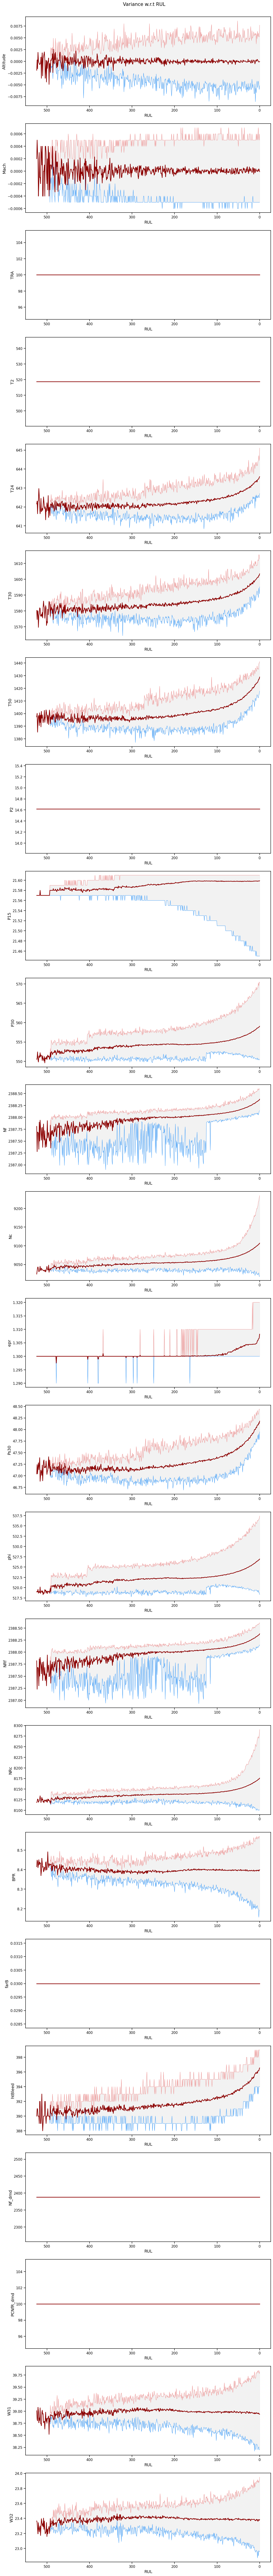

In [63]:
# count of indicators
indicators_count = len(indicators)
# aggregate dataframe by Time (min, mean, max)
df_grouped = dataframe.groupby(['RUL']).agg(['min', 'mean', 'max'])
    # create subplots
fig, axes = plt.subplots(nrows=indicators_count, ncols=1, figsize=(14, 130))
    # create and adjust superior title
fig.suptitle("Variance w.r.t RUL", fontsize=15)
fig.subplots_adjust(top=.975)
    # iterate over indicators
for i, indicator in enumerate(indicators):
    # choose indicator
    df_grouped_ind = df_grouped[indicator]
        # plot filling between max and min
    axes[i].fill_between(df_grouped_ind.index, df_grouped_ind['min'], df_grouped_ind['max'], color='gray',
                            alpha=0.1)
    # plot upper edge
    sns.lineplot(data=df_grouped_ind, ax=axes[i], x='RUL', y='max', color='lightcoral', linewidth=.7)
        # plot lower edge
    sns.lineplot(data=df_grouped_ind, ax=axes[i], x='RUL', y='min', color='dodgerblue', linewidth=.7)
        # plot mean line
    sns.lineplot(data=df_grouped_ind, ax=axes[i], x='RUL', y='mean', color='darkred', linewidth=2)
    
    # set y axis title
    axes[i].set_ylabel(indicator)
    # invert x-axis
    axes[i].invert_xaxis()
fig.savefig(f"variation.png",dpi=500,bbox_inches='tight')

Inferences

* There are various Altitude configurations
* There are various Mach configurations
* There is one TRA configuration = 100


* RUL decreases inversely with T24
* RUL decreases inversely with T30
* RUL decreases inversely with T50
* RUL decreases inversely with Nf
* RUL decreases inversely with Ps30
* RUL decreases inversely with NRf
* RUL decreases inversely with htBleed


* The engines P30 becomes unstable when the former approaches failure (divergent values near RUL = 0)
* The engines Nc becomes unstable when the former approaches failure (divergent values near RUL = 0)
* The engines phi becomes unstable when the former approaches failure (divergent values near RUL = 0)
* The engines NRc becomes unstable when the former approaches failure (divergent values near RUL = 0)
* The engines BPR becomes unstable when the former approaches failure (divergent values near RUL = 0)
* The engines W31 becomes unstable when the former approaches failure (divergent/two values near RUL = 0)
* The engines W32 becomes unstable when the former approaches failure (divergent/two values near RUL = 0)

#### Correlation plot

In [35]:
df_train.get_column_names()[5:-1]

['T2',
 'T24',
 'T30',
 'T50',
 'P2',
 'P15',
 'P30',
 'Nf',
 'Nc',
 'epr',
 'Ps30',
 'phi',
 'NRf',
 'NRc',
 'BPR',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32']

In [36]:
# Get the sensor names
sensors = df_train.get_column_names()[5:-1]

# Curate a list of columns to drop
# Drop the settings - as they are not sensors to be monitored
cols_to_drop = ['Altitude', 'Mach', 'TRA']

# Remove sensors with constant or near constant values
cols_const = [s for s in sensors if df_train[s].nunique() < 5]
print('Columns with constant values:', cols_const)
cols_to_drop += cols_const

# Find Sensors that too weakly correlate with the RUL
cols_weak_corr_target = np.array(sensors)[np.array([np.abs(df_train.correlation(s, 'RUL')) for s in sensors]) < 0.01].tolist()
print('Columns too weakly correlating with the RUL:', cols_weak_corr_target)
cols_to_drop += cols_weak_corr_target

# Find highly correlated columns
# TODO - depending on the "new" correlation and mutual information API
# cols_high_corr = ['NRc']
# print('Highly correlated (> 0.95) columns:', cols_high_corr)
cols_to_corr = [s for s in sensors if s not in cols_to_drop]
cols_to_corr_pairs = list(itertools.combinations(cols_to_corr, 2))
d_tmp = {'col_a': [], 'col_b': [], 'corr': []}
for i in cols_to_corr_pairs:
    corr= df_train.correlation(list(i))
    d_tmp['col_a'].append(i[0])
    d_tmp['col_b'].append(i[1])
    d_tmp['corr'].append(corr[0][1])
df_corr = vaex.from_dict(d_tmp)
cols_high_corr = df_corr[np.abs(df_corr.corr) > 0.95].col_b.tolist()
print('Highly correlated (> 0.95) columns:', cols_high_corr)
cols_to_drop += cols_high_corr

# Remove duplicates from the list of columns to drop
cols_to_drop = [*set(cols_to_drop)]

print()
print('Final list of columns to drop:', cols_to_drop)

Columns with constant values: ['T2', 'P2', 'epr', 'farB', 'Nf_dmd', 'PCNfR_dmd']
Columns too weakly correlating with the RUL: ['T2', 'P2', 'farB']
Highly correlated (> 0.95) columns: ['phi', 'NRf', 'NRc']

Final list of columns to drop: ['P2', 'Nf_dmd', 'phi', 'Mach', 'PCNfR_dmd', 'T2', 'epr', 'Altitude', 'NRc', 'TRA', 'NRf', 'farB']


invalid value encountered in divide


In [59]:
def pairwise_corr(df):
    """
    Calcualtes Pearson Correlation between each variable of the dataframe
    
    returns a print out of the correlation as a heatmap
    

    Arguments
    ---------
    df_scaled: dataframe 

    """
    # get correlations of each variable in dataset/feature set
    corrMatrix = df.corr()
    # get index
    top_corr_features = corrMatrix.index

    #plot heat map
    plt.figure(figsize=(20,20))
    # create mask 
    mask = np.triu(df[top_corr_features].corr())
    # plot heatmap
    ax = sns.heatmap(df[top_corr_features].corr(),annot=True, vmin=-1, vmax=1, center= 0, mask=mask, fmt='.2f', cmap="RdYlGn")
    plt.savefig("Correlation Heatmap",dpi=500,bbox_inches="tight")

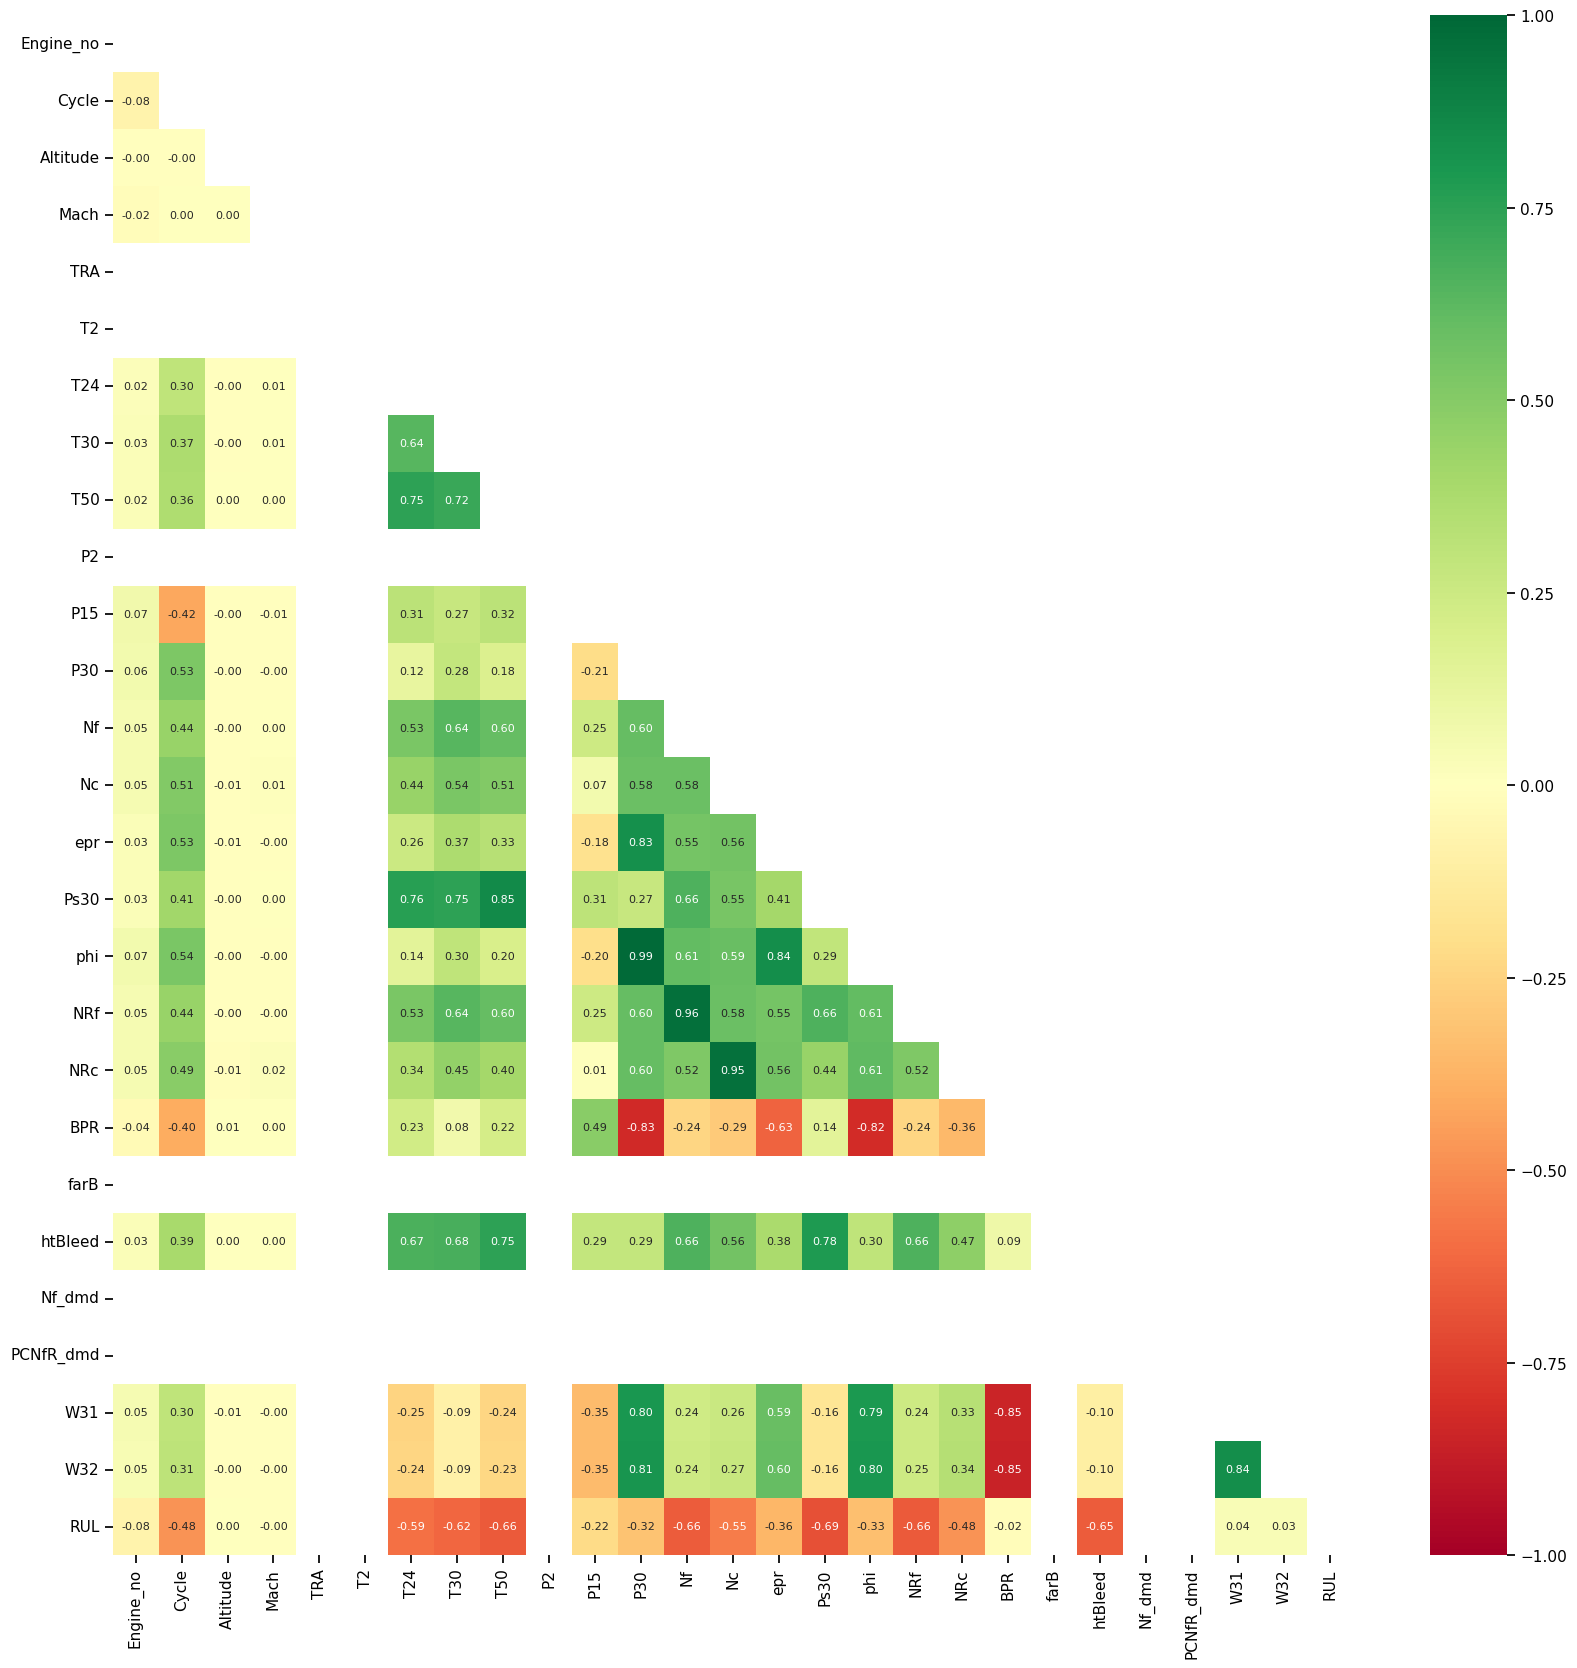

In [60]:
pairwise_corr(dataframe)


* phi contains similar information as P30
* NRf contains similar information as Nf
* NRc contains similar information as Nc

In [39]:
print(cols_to_drop) #from correlation-dash
#[0,1,2,3,4,5,9,10,11,14,20,21,22,23,24,25]
keys_idx= np.arange(27)
values_cols=df_train.get_column_names()
cols_idx = {keys_idx[i]: values_cols[i] for i in range(len(keys_idx))}
cols_idx

['P2', 'Nf_dmd', 'phi', 'Mach', 'PCNfR_dmd', 'T2', 'epr', 'Altitude', 'NRc', 'TRA', 'NRf', 'farB']


{0: 'Engine_no',
 1: 'Cycle',
 2: 'Altitude',
 3: 'Mach',
 4: 'TRA',
 5: 'T2',
 6: 'T24',
 7: 'T30',
 8: 'T50',
 9: 'P2',
 10: 'P15',
 11: 'P30',
 12: 'Nf',
 13: 'Nc',
 14: 'epr',
 15: 'Ps30',
 16: 'phi',
 17: 'NRf',
 18: 'NRc',
 19: 'BPR',
 20: 'farB',
 21: 'htBleed',
 22: 'Nf_dmd',
 23: 'PCNfR_dmd',
 24: 'W31',
 25: 'W32',
 26: 'RUL'}

## Data Pre-processing

In [40]:
ind=[0,1,2,3,4,5,9,10,11,14,20,21,22,23,24,25]
columns_to_be_dropped=[] # from prev modelling
for i in ind:
    columns_to_be_dropped.append(cols_idx.get(i))
columns_to_be_dropped

['Engine_no',
 'Cycle',
 'Altitude',
 'Mach',
 'TRA',
 'T2',
 'P2',
 'P15',
 'P30',
 'epr',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32']

In [41]:
df_train['W32']

Expression = W32
Length: 24,720 dtype: float64 (column)
--------------------------------------
    0  23.3537
    1  23.4491
    2  23.3669
    3  23.2951
    4  23.4583
     ...      
24715  22.9631
24716  22.9746
24717  23.0682
24718  23.0753
24719  23.0847

In [42]:
columns_to_be_dropped.append('RUL')

In [43]:
def process_targets(data_length, early_rul= None):
    """ datalength and earlyrul as input and creates target rul"""
    if early_rul == None:
        return np.arange(data_length-1,-1,-1)
    else:
        early_rul_duration = data_length - early_rul
        if early_rul_duration <=0:
            return np.arange(data_length-1,-1,-1)
        else:
            return np.append(early_rul*np.ones( shape= (early_rul_duration,)),np.arange(early_rul-1,-1,-1))

In [44]:
def process_input_data_with_targets(input_data, target_data = None, window_length = 1, shift = 1):
    """Depending on values of window_length and shift, this function generates batchs of data and targets 
    from input_data and target_data.
    
    Number of batches = np.floor((len(input_data) - window_length)/shift) + 1
    
    **We don't check input dimensions uisng exception handling. So readers should be careful while using these
    functions. If input data are not of desired dimension, either error occurs or something undesirable is 
    produced as output.**
    
    Arguments:
        input_data: input data to function (Must be 2 dimensional)
        target_data: input rul values (Must be 1D array)s
        window_length: window length of data
        shift: Distance by which the window moves for next batch. This is closely related to overlap
               between data. For example, if window length is 30 and shift is 1, there is an overlap of 
               29 data points between two consecutive batches.
        
    """
    num_batches = np.int(np.floor((len(input_data) - window_length)/shift)) + 1
    num_features = input_data.shape[1]
    output_data = np.repeat(np.nan, repeats = num_batches * window_length * num_features).reshape(num_batches, window_length,
                                                                                                  num_features)
    if target_data is None:
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
        return output_data
    else:
        output_targets = np.repeat(np.nan, repeats = num_batches)
        for batch in range(num_batches):
            output_data[batch,:,:] = input_data[(0+shift*batch):(0+shift*batch+window_length),:]
            output_targets[batch] = target_data[(shift*batch + (window_length-1))]
        return output_data, output_targets

In [45]:
def process_test_data(test_data_for_an_engine, window_length, shift, num_test_windows = 1):
    """ This function takes test data for an engine as first input. The next two inputs
    window_length and shift are same as other functins. 
    
    Finally it takes num_test_windows as the last input. num_test_windows sets how many examplles we
    want from test data (from last). By default it extracts only the last example.
    
    The function return last examples and number of last examples (a scaler) as output. 
    We need the second output later. If we are extracting more than 1 last examples, we have to 
    average their prediction results. The second scaler halps us do just that.
    """
    max_num_test_batches = np.int(np.floor((len(test_data_for_an_engine) - window_length)/shift)) + 1
    if max_num_test_batches < num_test_windows:
        required_len = (max_num_test_batches -1)* shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          windoحw_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, max_num_test_batches
    else:
        required_len = (num_test_windows - 1) * shift + window_length
        batched_test_data_for_an_engine = process_input_data_with_targets(test_data_for_an_engine[-required_len:, :],
                                                                          target_data = None,
                                                                          window_length = window_length, shift = shift)
        return batched_test_data_for_an_engine, num_test_windows


In [46]:
print(df_train.get_column_names())
print(df_test.get_column_names())

['Engine_no', 'Cycle', 'Altitude', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32', 'RUL']
['Engine_no', 'Cycle', 'Altitude', 'Mach', 'TRA', 'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32', 'RUL']


In [47]:
columns_to_be_dropped

['Engine_no',
 'Cycle',
 'Altitude',
 'Mach',
 'TRA',
 'T2',
 'P2',
 'P15',
 'P30',
 'epr',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32',
 'RUL']

In [48]:
#df_train.ml.minmax_scaler(features=cols_to_scale, prefix='feat_')
#df_train.drop()

#df_train.drop(columns_to_be_dropped)
df_test.drop(columns_to_be_dropped)

#       T24     T30      T50      Nf       Nc       Ps30    phi     NRf      NRc      BPR
0       641.94  1581.93  1396.93  2387.93  9048.65  47.09   521.89  2387.94  8133.48  8.376
1       642.02  1584.86  1398.9   2387.94  9046.53  47.08   521.85  2388.01  8137.44  8.4062
2       641.68  1581.78  1391.92  2387.97  9054.92  47.15   522.1   2387.94  8138.25  8.3553
3       642.2   1584.53  1395.34  2387.94  9055.04  47.26   522.45  2387.96  8137.07  8.3709
4       642.46  1589.03  1395.86  2388.01  9048.59  46.94   521.91  2387.97  8134.2   8.4146
...     ...     ...      ...      ...      ...      ...     ...     ...      ...      ...
16,591  643.04  1594.99  1411.28  2388.24  9088.31  47.61   529.23  2388.24  8162.24  8.2939
16,592  642.47  1591.27  1417.64  2388.29  9085.35  47.75   529.27  2388.26  8163.24  8.3247
16,593  642.7   1593.81  1412.7   2388.23  9084.29  47.6    529.48  2388.28  8162.12  8.3264
16,594  642.19  1595.63  1406.58  2388.24  9092.52  47.69   529.39  2388.33  8164.2   8.2908
16,595  643.19  1592.54  1407.2   2388.3   9094.27  47.71   529.59  2388.29  8169.24  8.3191

In [49]:
train_df= df_train.to_pandas_df().copy()
test_df= df_test.to_pandas_df().copy()

In [50]:
"""cols_to_scale = df_train.get_column_names()[2:-1]

# # Normalize in range (0, 1)
# df_train = df_train.ml.minmax_scaler(features=cols_to_scale)

# Normalize in range (0, 1)
df_train = df_train.ml.minmax_scaler(features=cols_to_scale, prefix='feat_')

# Get the scaled columns and from them create columns to be transformed into features
scaled_cols = df_train.get_column_names(regex='^feat')
for col in scaled_cols:
    feat_name = col.replace('feat', 'minmax_scaled')
    df_train[feat_name] = df_train[col].copy()


# Save the pipeline up to this point, to be used for visualising explanations via SHAP
df_train.pipeline.save('./model/pipeline_expl.json')"""

"cols_to_scale = df_train.get_column_names()[2:-1]\n\n# # Normalize in range (0, 1)\n# df_train = df_train.ml.minmax_scaler(features=cols_to_scale)\n\n# Normalize in range (0, 1)\ndf_train = df_train.ml.minmax_scaler(features=cols_to_scale, prefix='feat_')\n\n# Get the scaled columns and from them create columns to be transformed into features\nscaled_cols = df_train.get_column_names(regex='^feat')\nfor col in scaled_cols:\n    feat_name = col.replace('feat', 'minmax_scaled')\n    df_train[feat_name] = df_train[col].copy()\n\n\n# Save the pipeline up to this point, to be used for visualising explanations via SHAP\ndf_train.pipeline.save('./model/pipeline_expl.json')"

In [51]:
df_train[df_train.get_column_names()[2:-1]]

#       Altitude    Mach     TRA    T2      T24     T30      T50      P2     P15    P30     Nf       Nc       epr    Ps30    phi     NRf      NRc      BPR     farB    htBleed    Nf_dmd    PCNfR_dmd    W31    W32
0       -0.0005     0.0004   100.0  518.67  642.36  1583.23  1396.84  14.62  21.61  553.97  2387.96  9062.17  1.3    47.3    522.31  2388.01  8145.32  8.4246  0.03    391        2388      100.0        39.11  23.3537
1       0.0008      -0.0003  100.0  518.67  642.5   1584.69  1396.89  14.62  21.61  554.55  2388.0   9061.78  1.3    47.23   522.42  2388.03  8152.85  8.4403  0.03    392        2388      100.0        38.99  23.4491
2       -0.0014     -0.0002  100.0  518.67  642.18  1582.35  1405.61  14.62  21.61  554.43  2388.03  9070.23  1.3    47.22   522.03  2388.0   8150.17  8.3901  0.03    391        2388      100.0        38.85  23.3669
3       -0.002      0.0001   100.0  518.67  642.92  1585.61  1392.27  14.62  21.61  555.21  2388.0   9064.57  1.3    47.24   522.49  2388.08  8146.56  8.3878  0.03    392        2388      100.0        38.96  23.2951
4       0.0016      0.0      100.0  518.67  641.68  1588.63  1397.65  14.62  21.61  554.74  2388.04  9076.14  1.3    47.15   522.58  2388.03  8147.8   8.3869  0.03    392        2388      100.0        39.14  23.4583
...     ...         ...      ...    ...     ...     ...      ...      ...    ...    ...     ...      ...      ...    ...     ...     ...      ...      ...     ...     ...        ...       ...          ...    ...
24,715  -0.0016     -0.0003  100.0  518.67  643.78  1596.01  1424.11  14.62  21.61  551.86  2388.25  9070.82  1.3    48.27   519.66  2388.3   8138.08  8.5036  0.03    394        2388      100.0        38.44  22.9631
24,716  0.0034      -0.0003  100.0  518.67  643.29  1596.38  1429.14  14.62  21.61  551.86  2388.23  9064.6   1.3    48.13   519.91  2388.28  8144.36  8.5174  0.03    395        2388      100.0        38.5   22.9746
24,717  -0.0016     0.0004   100.0  518.67  643.84  1604.53  1431.41  14.62  21.61  551.3   2388.25  9063.45  1.3    48.18   519.44  2388.24  8135.95  8.5223  0.03    396        2388      100.0        38.39  23.0682
24,718  -0.0023     0.0004   100.0  518.67  643.94  1597.56  1426.57  14.62  21.61  550.69  2388.26  9062.22  1.3    48.05   520.01  2388.26  8141.24  8.5148  0.03    395        2388      100.0        38.31  23.0753
24,719  0.0         0.0003   100.0  518.67  643.64  1599.04  1436.06  14.62  21.61  550.96  2388.26  9066.52  1.3    48.12   519.48  2388.24  8136.98  8.515   0.03    396        2388      100.0        38.56  23.0847

In [52]:
df_test.shape

(16596, 27)

#### Vaex Pre-processing

In [53]:

cols_to_scale = df_train.get_column_names()[2:-1]

# # Normalize in range (0, 1)
# df_train = df_train.ml.minmax_scaler(features=cols_to_scale)

# Normalize in range (0, 1)
df_train_vaex = df_train.ml.minmax_scaler(features=cols_to_scale, prefix='feat_')

# Get the scaled columns and from them create columns to be transformed into features
scaled_cols = df_train_vaex.get_column_names(regex='^feat')
for col in scaled_cols:
    feat_name = col.replace('feat', 'minmax_scaled')
    df_train_vaex[feat_name] = df_train_vaex[col].copy()


# Save the pipeline up to this point, to be used for visualising explanations via SHAP
df_train_vaex.state_write('model/pipeline_expl.json')

In [54]:
#preparing data for lstm
features = df_train_vaex.get_column_names(regex='^feat_')
features_to_reshape = features + ['RUL']
target = 'RUL_target'
sequence_length = 50
batch_size = 192

In [55]:
def reshape_data(df, groupby, shift_columns, sequence_length):
    '''Reshape the data to be suitable for LSTM input
    :param groupby: groupby the sequences by this column
    :param shift_columns: a list of columns to be shifted
    :sequence length: The length of each sequence. If a group has less samples than this number, it will be dropped.
    :return: The refshaped/transformed DataFrame
    '''
    return vaex.concat([df_tmp.shift(periods=(0, sequence_length), column=shift_columns, trim=True) for _, df_tmp in df.groupby(groupby) if len(df_tmp) > sequence_length])


# Apply the transformation to the DataFrame
df_train_vaex= reshape_data(df_train_vaex,groupby='Engine_no', 
                              shift_columns=features_to_reshape, 
                              sequence_length=sequence_length)


# Get the target value for each sequence
df_train_vaex['RUL_target'] = df_train_vaex.RUL[:, -1]


In [56]:
df_train_vaex

invalid value encountered in divide


#       Engine_no    Cycle    RUL                                                  minmax_scaled_Altitude    minmax_scaled_Mach    minmax_scaled_TRA    minmax_scaled_T2    minmax_scaled_T24    minmax_scaled_T30    minmax_scaled_T50    minmax_scaled_P2    minmax_scaled_P15    minmax_scaled_P30    minmax_scaled_Nf    minmax_scaled_Nc     minmax_scaled_epr    minmax_scaled_Ps30    minmax_scaled_phi    minmax_scaled_NRf    minmax_scaled_NRc    minmax_scaled_BPR    minmax_scaled_farB    minmax_scaled_htBleed    minmax_scaled_Nf_dmd    minmax_scaled_PCNfR_dmd    minmax_scaled_W31    minmax_scaled_W32    feat_W31                                             phi     Mach     W31    feat_T24                                             BPR     feat_Nf_dmd                                          feat_P30                                             epr    htBleed    feat_NRc                                             feat_NRf                                             P2     feat_PCNfR_dmd                                       feat_Altitude                                        T24     feat_farB                                            P30     feat_T50                                             P15    feat_Mach                                            Altitude    feat_Nc                                              feat_Ps30                                            feat_P2                                              T30      feat_W32                                             feat_phi                                             feat_T30                                             feat_htBleed                                         Nc       PCNfR_dmd    feat_P15                                             TRA    feat_epr                                             feat_TRA                                             feat_T2                                              feat_BPR                                             Nf       T50      Nf_dmd    T2      NRc      NRf      feat_Nf                                              farB    W32      Ps30    RUL_target
0       1            1        'masked_array(data=[258, 257, 256, 255, 254, 253...  0.4709302325581395        0.7692307692307693    nan                  nan                 0.35597189695550074  0.37052260716382873  0.30858034321372746  nan                 1.0                  0.20881226053639917  0.6235294117647405  0.20423348893099944  0.3333333333333333   0.34857142857142825   0.23127865511971293  0.6428571428572588   0.23911562843820225  0.6477547078705951   nan                   0.2727272727272727       nan                     nan                        0.5595238095238083   0.4463308284627516   'masked_array(data=[0.5595238095238083, 0.488095...  522.31  0.0004   39.11  'masked_array(data=[0.35597189695550074, 0.38875...  8.4246  'masked_array(data=[--, --, --, --, --, --, --, ...  'masked_array(data=[0.20881226053639917, 0.23659...  1.3    391        'masked_array(data=[0.23911562843820225, 0.27856...  'masked_array(data=[0.6428571428572588, 0.654761...  14.62  'masked_array(data=[--, --, --, --, --, --, --, ...  'masked_array(data=[0.4709302325581395, 0.546511...  642.36  'masked_array(data=[--, --, --, --, --, --, --, ...  553.97  'masked_array(data=[0.30858034321372746, 0.30936...  21.61  'masked_array(data=[0.7692307692307693, 0.230769...  -0.0005     'masked_array(data=[0.20423348893099944, 0.20243...  'masked_array(data=[0.34857142857142825, 0.30857...  'masked_array(data=[--, --, --, --, --, --, --, ...  1583.23  'masked_array(data=[0.4463308284627516, 0.534836...  'masked_array(data=[0.23127865511971293, 0.23688...  'masked_array(data=[0.37052260716382873, 0.39909...  'masked_array(data=[0.2727272727272727, 0.363636...  9062.17  100.0        'masked_array(data=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0...  100.0  'masked_array(data=[0.3333333333333333, 0.333333...  'masked_array(data=[--, --, --, --, --, --, --, ...  'masked_array(data=[--, --, --, --, --, --, --, ...  'm

In [57]:
# Use the transformations of the train df and apply them to the validationd f
df_val_vaex = df_train_vaex.state_load(df_test.copy(), trusted=True)
df_val_vaex

FileNotFoundError: [Errno 2] No such file or directory: 'data_test'

### Pandas pre-processing(from jupyter)

In [ ]:
columns_to_be_dropped

['Engine_no',
 'Cycle',
 'Altitude',
 'Mach',
 'TRA',
 'T2',
 'P2',
 'P15',
 'P30',
 'epr',
 'farB',
 'htBleed',
 'Nf_dmd',
 'PCNfR_dmd',
 'W31',
 'W32',
 'RUL']

In [ ]:

window_length = 30
shift = 1
early_rul = 125           
processed_train_data = []
processed_train_targets = []

# How many test windows to take for each engine. If set to 1 (this is the default), only last window of test data for 
# each engine is taken. If set to a different number, that many windows from last are taken. 
# Final output is the average output of all windows.
num_test_windows = 5     
processed_test_data = []
num_test_windows_list = []

#columns_to_be_dropped = [0,1,2,3,4,5,9,10,14,20,22,23]
#columns_to_be_dropped_test =['id','op1','op2','op3', 's1', 's5', 's6','s10','s16', 's18', 's19','s22','s23']
train_data_first_column = train_df['Engine_no']
test_data_first_column =test_df['Engine_no']

# Scale data for all engines
scaler = MinMaxScaler(feature_range = (-1,1))
train= scaler.fit_transform(train_df.drop(columns = ['RUL','Engine_no']))
test = scaler.transform(test_df.drop(columns = ['RUL','Engine_no']))



train_data = pd.DataFrame(data = np.c_[train_data_first_column, train])
test_data = pd.DataFrame(data = np.c_[test_data_first_column, test])

num_train_machines = len(train_data[0].unique())
num_test_machines = len(test_data[0].unique())

# Process training and test data sepeartely as number of engines in training and test set may be different.
# As we are doing scaling for full dataset, we are not bothered by different number of engines in training and test set.

# Process training data
for i in np.arange(1, num_train_machines + 1):
    temp_train_data = train_data[train_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from training data
    if (len(temp_train_data) < window_length):
        print("Train engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
        
    temp_train_targets = process_targets(data_length = temp_train_data.shape[0], early_rul = early_rul)
    data_for_a_machine, targets_for_a_machine = process_input_data_with_targets(temp_train_data, temp_train_targets, 
                                                                                window_length = window_length, shift = shift)
    
    processed_train_data.append(data_for_a_machine)
    processed_train_targets.append(targets_for_a_machine)

processed_train_data = np.concatenate(processed_train_data)
processed_train_targets = np.concatenate(processed_train_targets)

# Process test data
true_rul= pd.read_csv('data/01_raw/RUL_FD003.txt', sep = '\s+', header = None)
for i in np.arange(1, num_test_machines + 1):
    temp_test_data = test_data[test_data[0] == i].drop(columns = [0]).values
    
    # Verify if data of given window length can be extracted from test data
    if (len(temp_test_data) < window_length):
        print("Test engine {} doesn't have enough data for window_length of {}".format(i, window_length))
        raise AssertionError("Window length is larger than number of data points for some engines. "
                             "Try decreasing window length.")
    
    # Prepare test data
    test_data_for_an_engine, num_windows = process_test_data(temp_test_data, window_length = window_length, shift = shift,
                                                             num_test_windows = num_test_windows)
    
    processed_test_data.append(test_data_for_an_engine)
    num_test_windows_list.append(num_windows)

processed_test_data = np.concatenate(processed_test_data)

true_rul = true_rul[0].values

# Shuffle training data
index = np.random.permutation(len(processed_train_targets))
processed_train_data, processed_train_targets = processed_train_data[index], processed_train_targets[index]
print("Processed trianing data shape: ", processed_train_data.shape)
print("Processed training ruls shape: ", processed_train_targets.shape)
print("Processed test data shape: ", processed_test_data.shape)
print("True RUL shape: ", true_rul.shape)

Processed trianing data shape:  (21820, 30, 25)
Processed training ruls shape:  (21820,)
Processed test data shape:  (500, 30, 25)
True RUL shape:  (100,)


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
processed_train_data, processed_val_data, processed_train_targets, processed_val_targets = train_test_split(processed_train_data,
                                                                                                            processed_train_targets,
                                                                                                            test_size = 0.2,
                                                                                                            random_state = 83)
print("Processed train data shape: ", processed_train_data.shape)
print("Processed validation data shape: ", processed_val_data.shape)
print("Processed train targets shape: ", processed_train_targets.shape)
print("Processed validation targets shape: ", processed_val_targets.shape)

Processed train data shape:  (17456, 30, 25)
Processed validation data shape:  (4364, 30, 25)
Processed train targets shape:  (17456,)
Processed validation targets shape:  (4364,)


# Defining Metrics

In [ ]:
def get_regression_metrics(model, actual, predicted):
    
    """Calculate main regression metrics.
    
    Args:
        model (str): The model name identifier
        actual (series): Contains the test label values
        predicted (series): Contains the predicted values
        
    Returns:
        dataframe: The combined metrics in single dataframe
    
    
    """
    regr_metrics = {
                        'Root Mean Squared Error' : metrics.mean_squared_error(actual, predicted)**0.5,
                        'Mean Absolute Error' : metrics.mean_absolute_error(actual, predicted),
                        'R^2' : metrics.r2_score(actual, predicted),
                        'Explained Variance' : metrics.explained_variance_score(actual, predicted)
                   }

    #return reg_metrics
    df_regr_metrics = pd.DataFrame.from_dict(regr_metrics, orient='index')
    df_regr_metrics.columns = [model]
    return df_regr_metrics

# TCN- LSTM Model

In [ ]:
def compiled_model(lr=0.001,drop_CNN=0,drop_dense=0.2,kernel_size=3):
    model= Sequential()
    input_shape= (window_length, processed_train_data.shape[2])
    model.add(TCN(input_shape= input_shape,kernel_size=2,use_skip_connections=False,use_batch_norm=False, use_weight_norm=False,
        use_layer_norm=False,return_sequences=True))
    #model.add(Conv1D(128, kernel_size=kernel_size, padding = "same", activation="relu"))
    #model.add(Dropout(drop_CNN))
    #model.add(MaxPooling1D(pool_size=2, padding='same'))
    #model.add(Conv1D(128,kernel_size=kernel_size, padding = "same", activation="relu"))
    #model.add(Dropout(drop_CNN))
    #model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units = 128, return_sequences=True))
    model.add(LSTM(units = 64, return_sequences=False))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(drop_dense))
    model.add(Dense(1, activation = 'relu'))
    model.add(Dense(1))
    opt = tensorflow.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss='mse')
    return model

In [ ]:
def scheduler(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001
callback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)
model_lstm_tcn = compiled_model()
history = model_lstm_tcn.fit(processed_train_data, processed_train_targets, epochs = 10,
                    validation_data = (processed_val_data, processed_val_targets),callbacks=[callback],
                    batch_size = 64, verbose = 2)

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



2023-05-13 00:38:46.327777: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-13 00:38:46.327882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train on 17456 samples, validate on 4364 samples


2023-05-13 00:38:46.755399: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-13 00:38:46.755425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-13 00:38:46.781297: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2023-05-13 00:38:46.796783: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-13 00:38:46.797207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 00:38:46.865846: I tensorflow/core/grappler/optimizers/custom_graph


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10


2023-05-13 00:38:47.082641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 00:38:47.117826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-13 00:38:47.128789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
2023-05-13 00:40:05.009343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


17456/17456 - 87s - loss: 9629.6032 - val_loss: 9451.0400 - lr: 0.0010 - 87s/epoch - 5ms/sample

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
17456/17456 - 82s - loss: 9581.2161 - val_loss: 9403.3279 - lr: 0.0010 - 82s/epoch - 5ms/sample

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
17456/17456 - 81s - loss: 9533.0659 - val_loss: 9355.8151 - lr: 0.0010 - 81s/epoch - 5ms/sample

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
17456/17456 - 82s - loss: 9485.1377 - val_loss: 9308.5317 - lr: 0.0010 - 82s/epoch - 5ms/sample

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
17456/17456 - 82s - loss: 9437.3764 - val_loss: 9261.4519 - lr: 0.0010 - 82s/epoch - 5ms/sample

Epoch 6: LearningRateScheduler setting learning rate to 0.0001.
Epoch 6/10
17456/17456 - 80s - loss: 9411.0914 - val_loss: 9256.7464 - lr: 1.0000e-04 - 80s/epoch - 5ms/sample

Epoch 7: LearningRateScheduler setting lear

In [ ]:
print(model_lstm_tcn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn (TCN)                   (None, 30, 64)            95744     
                                                                 
 time_distributed (TimeDistr  (None, 30, 64)           0         
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 30, 128)           98816     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

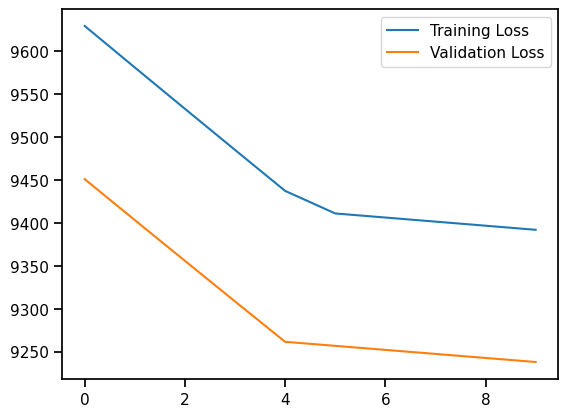

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()